In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [5]:
bikeshare = pd.read_csv('./bikeshare_train_data.csv',parse_dates=['Date'])

In [6]:
temp_reg = LinearRegression()
temp_reg.fit(bikeshare.max_temp.values.reshape(-1,1),
            bikeshare.num_trips)
temp_preds = temp_reg.predict(bikeshare.max_temp.values.reshape(-1,1))

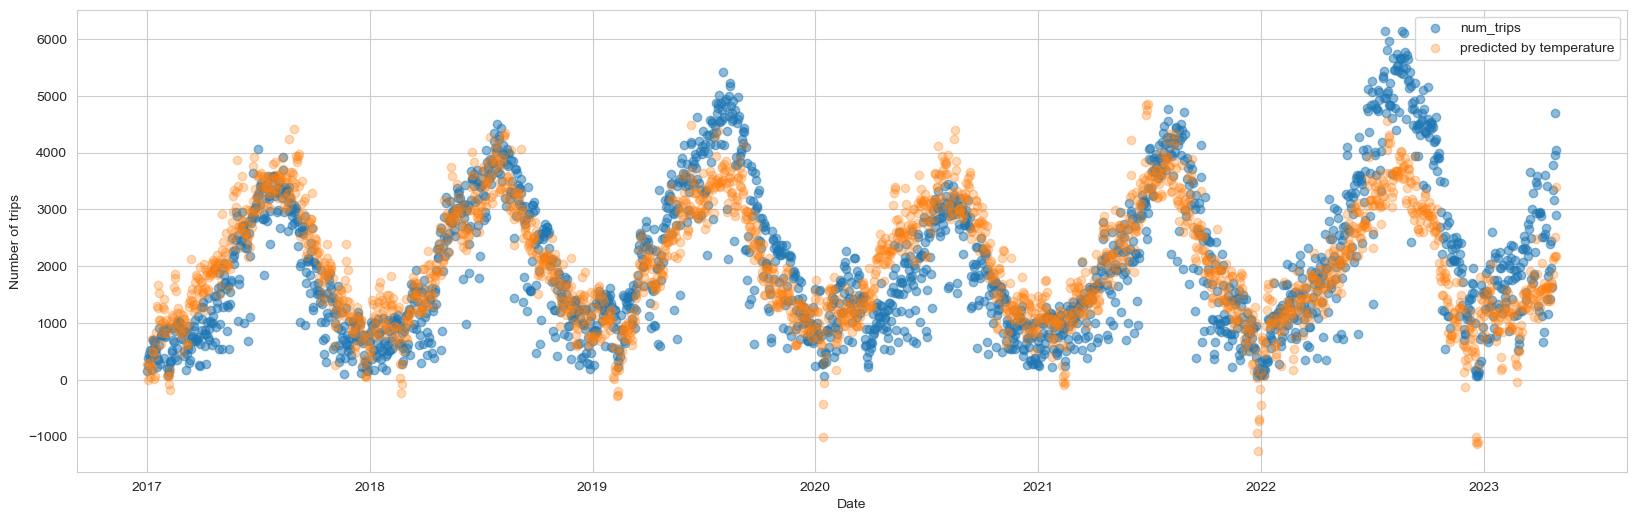

In [8]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           bikeshare.num_trips,
           alpha=0.5,
           label='num_trips')

plt.scatter(bikeshare.Date,
           temp_preds,
           alpha=0.3,
           label='predicted by temperature')

plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.legend()

plt.show()

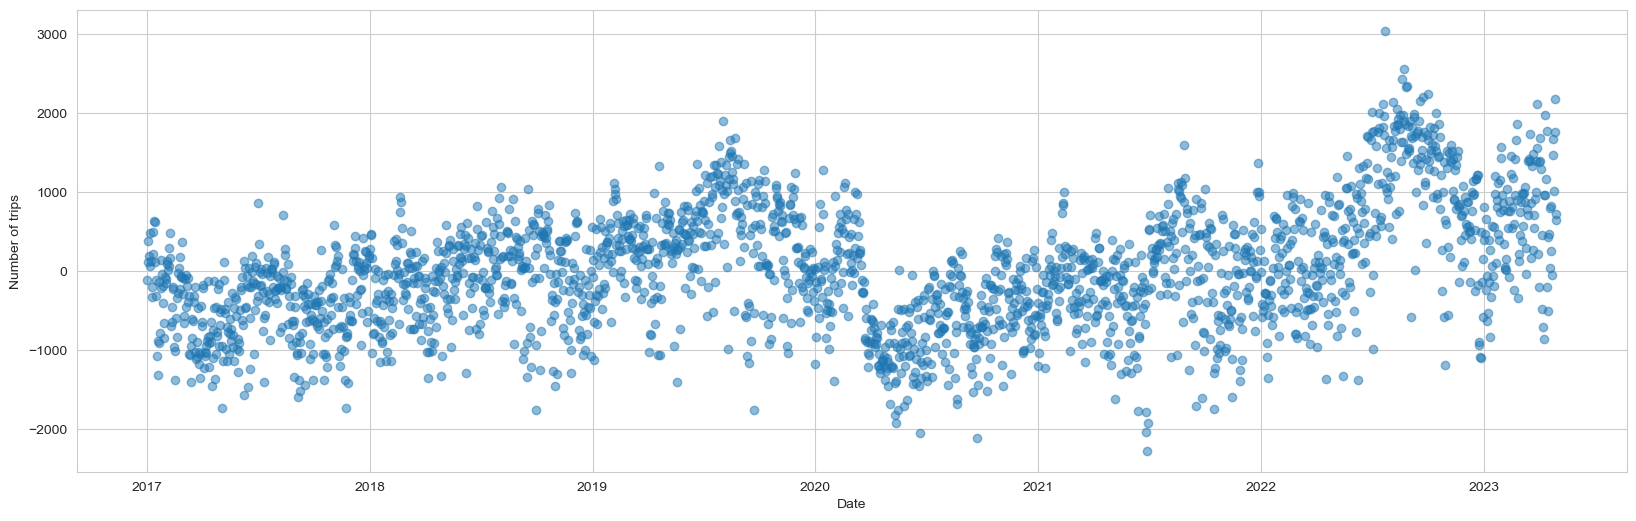

In [10]:
temp_residuals = bikeshare.num_trips - temp_preds

plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           temp_residuals,
           alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Number of trips')


plt.show()

So ``max_temp`` accounts for the seasonality, and we can figure out the trend from the above plot.

In [37]:
bikeshare['temp_residuals'] = temp_residuals
date1 = pd.Timestamp(year=2020,month=2,day=1)
date2 =  pd.Timestamp(year=2020,month=4,day=1)
bikeshare_piece1 = bikeshare.loc[bikeshare.Date < date1]
bikeshare_piece2 = bikeshare.loc[bikeshare.Date >= date2]

piece1_reg = LinearRegression()
piece1_reg.fit(bikeshare_piece1.index.values.reshape(-1,1),
               bikeshare_piece1.temp_residuals)

piece2_reg = LinearRegression()
piece2_reg.fit(bikeshare_piece2.index.values.reshape(-1,1),
               bikeshare_piece2.temp_residuals)

piece1_preds = piece1_reg.predict(bikeshare_piece1.index.values.reshape(-1,1))
piece2_preds = piece2_reg.predict(bikeshare_piece2.index.values.reshape(-1,1))

In [41]:
bikeshare_interim = bikeshare.loc[(bikeshare.Date >= date1) & (bikeshare.Date < date2)]
interim_reg = LinearRegression()
interim_reg.fit(bikeshare_interim.index.values.reshape(-1,1),
               bikeshare_interim.temp_residuals)
interim_preds = interim_reg.predict(bikeshare_interim.index.values.reshape(-1,1))

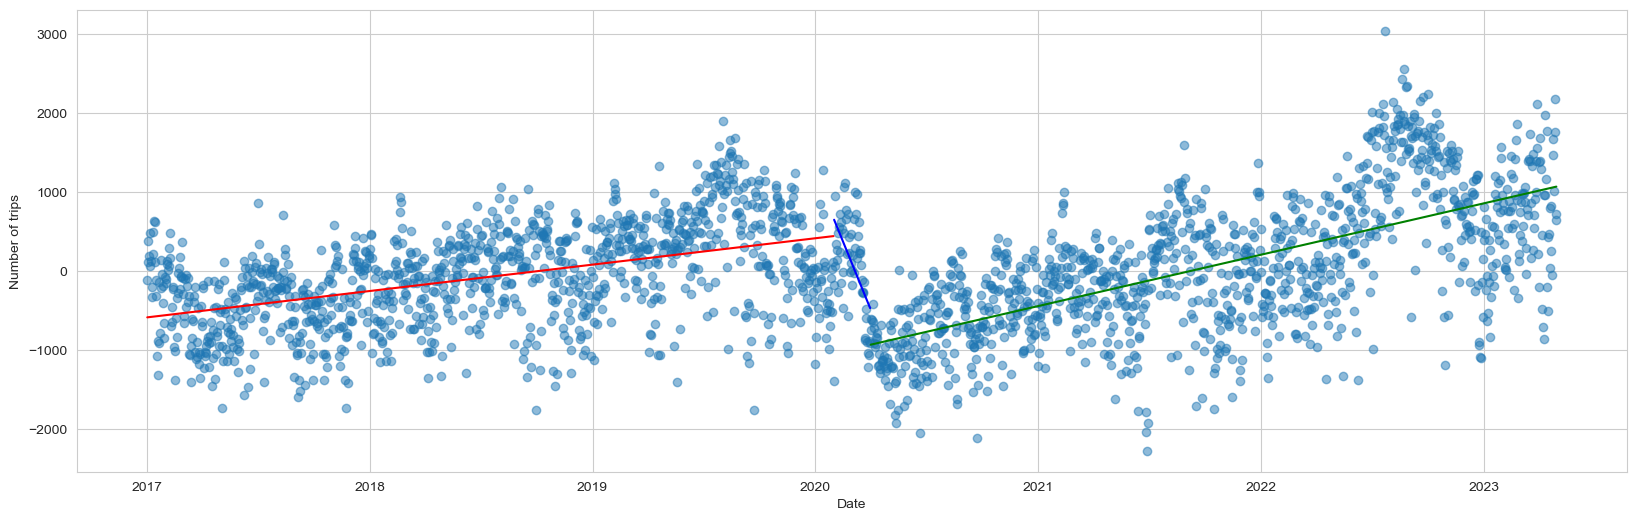

In [42]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           temp_residuals,
           alpha=0.5)

plt.plot(bikeshare_piece1.Date,
        piece1_preds,
        'r-')

plt.plot(bikeshare_interim.Date,
        interim_preds,
        'b')

plt.plot(bikeshare_piece2.Date,
        piece2_preds,
        'g-')

plt.xlabel('Date')
plt.ylabel('Number of trips')


plt.show()

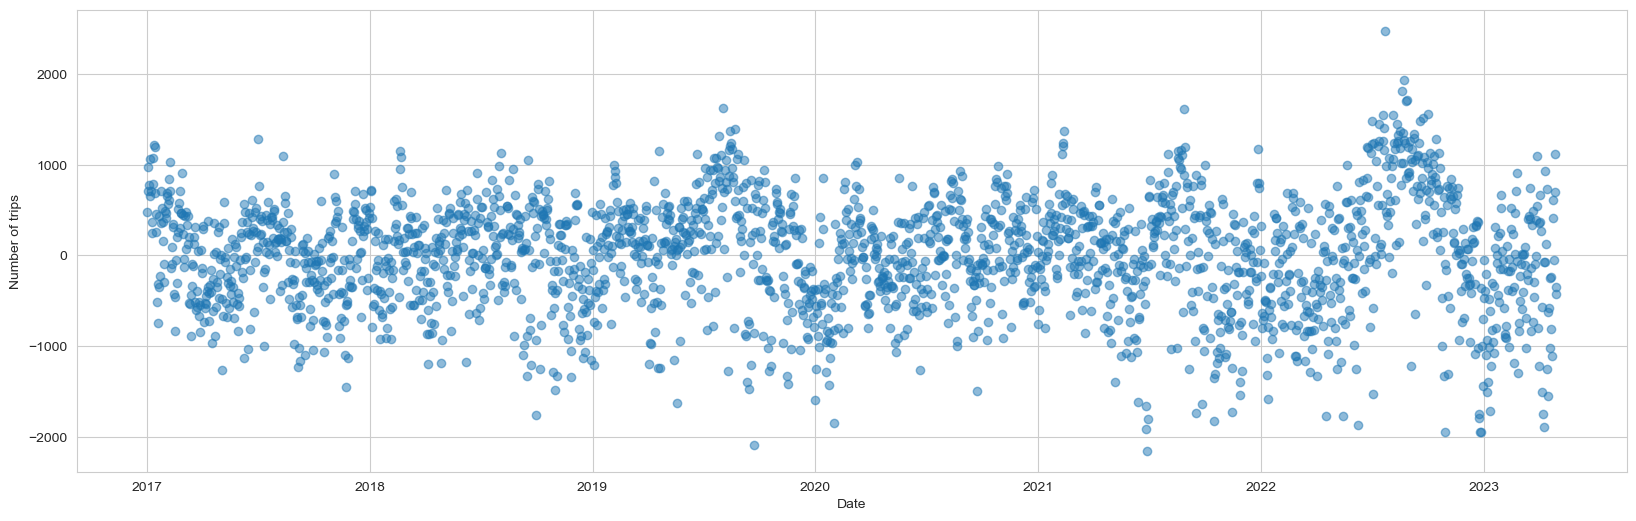

In [43]:
piecewise_preds = np.concatenate((piece1_preds, interim_preds, piece2_preds))
total_residuals = temp_residuals - piecewise_preds

plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           total_residuals,
           alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Number of trips')


plt.show()

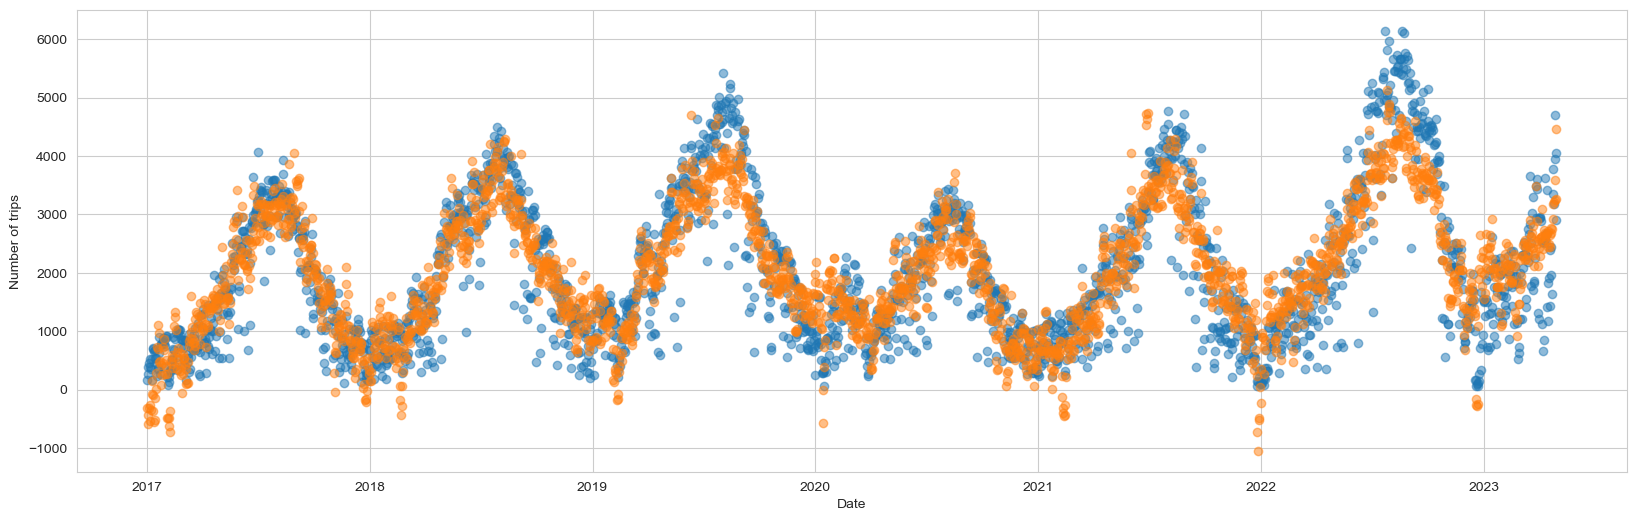

In [44]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           bikeshare.num_trips,
           alpha=0.5,
           label='num_trips')

plt.scatter(bikeshare.Date,
           piecewise_preds + temp_preds,
           alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Number of trips')


plt.show()

So, ``piecewise_preds`` is the demand trend we can use. For future forecasting and predictions based on weather past 2023-05, just add on predictions from ``piece2_reg``.

In [49]:
bikeshare['adj_num_trips'] = bikeshare.num_trips - piecewise_preds
bikeshare.adj_num_trips += np.abs(bikeshare.iloc[np.argmin(bikeshare.adj_num_trips)].adj_num_trips)

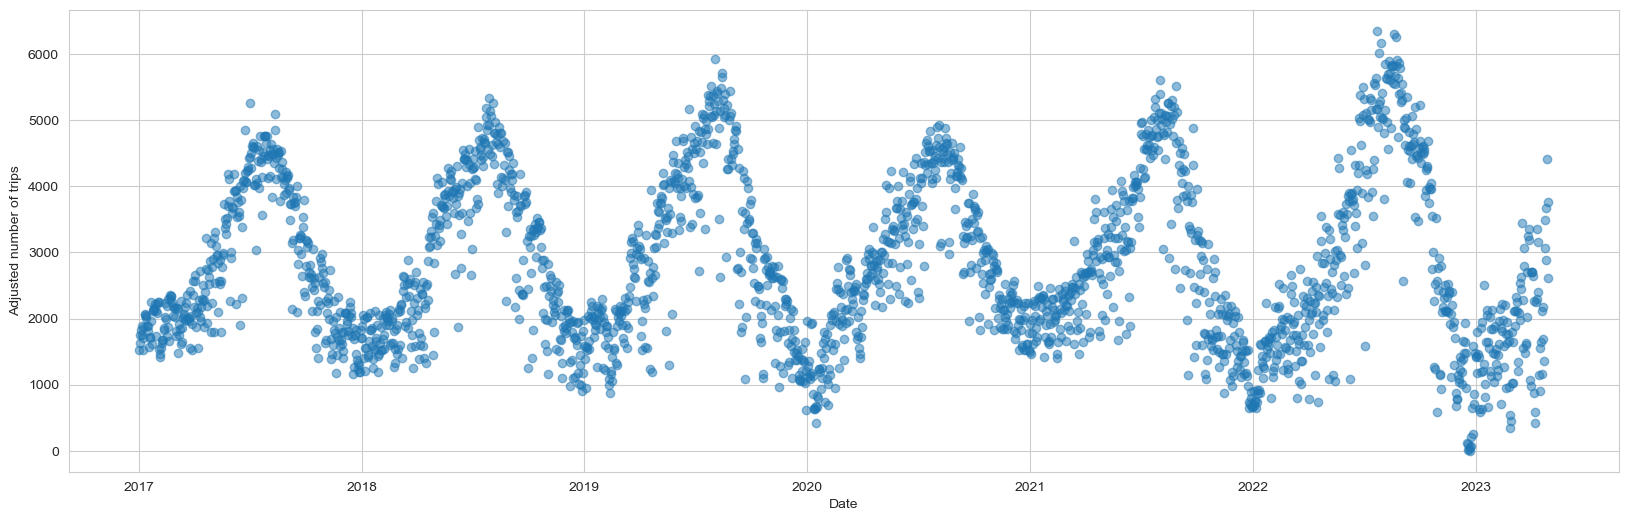

In [50]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.Date,
           bikeshare.adj_num_trips,
           alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Adjusted number of trips')


plt.show()

In [51]:
bikeshare.to_csv('bikeshare_train_data_pcwsdetrend.csv', index=False, index_label='Date')